<a href="https://colab.research.google.com/github/sparsh-goil/DeepLearning-Labs/blob/master/LabAssignment3_201701061.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models  import Sequential
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Neural Network Model Architecture**

In [ ]:
class NeuralNetwork:
  def __init__(self,batch_size,input_size,hidden_layer1_size,hidden_layer2_size,hidden_layer3_size,output_size,learning_rate,epochs):
    self.input_size = input_size
    self.batch_size = batch_size
    self.hidden_layer1_size = hidden_layer1_size
    self.hidden_layer2_size = hidden_layer2_size
    self.hidden_layer3_size = hidden_layer3_size
    self.output_size = output_size
    tf.random.set_seed(42)
    self.W1 = self.initialize_weights(input_size,hidden_layer1_size)
    self.W2 = self.initialize_weights(hidden_layer1_size,hidden_layer2_size)
    self.W3 = self.initialize_weights(hidden_layer2_size,hidden_layer3_size)
    self.W4 = self.initialize_weights(hidden_layer3_size,output_size)
    self.B1 = tf.random.normal(shape = [batch_size,hidden_layer1_size],mean=0,stddev=1,dtype=tf.dtypes.float32)
    self.B2 = tf.random.normal(shape = [batch_size,hidden_layer2_size],mean=0,stddev=1,dtype=tf.dtypes.float32)
    self.B3 = tf.random.normal(shape = [batch_size,hidden_layer3_size],mean=0,stddev=1,dtype=tf.dtypes.float32)
    self.B4 = tf.random.normal(shape = [batch_size,output_size],mean=0,stddev=1,dtype=tf.dtypes.float32)
    self.act = {
        'tanh':tf.math.tanh,
        'relu':tf.nn.relu,
        'sigmoid':tf.math.sigmoid,
        'softmax':tf.nn.softmax,
    }
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.weights = []
    self.layer_outputs = []

  def initialize_weights(self,X,Y):
    weights = tf.random.normal(shape=[X,Y],mean=0,stddev=1,dtype=tf.dtypes.float32)
    return weights
    
  def forward(self,X_batch,activation,activation_output,extra):
    #hidden layer1
    Z1 = tf.add(tf.matmul(X_batch,self.W1),self.B1)
    A1 = self.act[activation](Z1)
    #hidden layer2
    Z2 = tf.add(tf.matmul(A1,self.W2),self.B2)
    A2 = tf.nn.relu(Z2)
    #hidden layer 3
    Z3 = tf.add(tf.matmul(A2,self.W3),self.B3)
    A3 = self.act[activation](Z3)
    #ouput layer
    Z4 = tf.add(tf.matmul(A3,self.W4),self.B4)
    Output = self.act[activation_output](Z4)
    if extra == True:
      return Z1,A1,Z2,A2,Z3,A3,Z4,Output
    else:
      return Output

  def backward(self,X_batch,y_batch,activation,activation_output):
    # Perform forward propagation
    Z1,A1,Z2,A2,Z3,A3,Z4,A4 = self.forward(X_batch,activation,activation_output,True)

    # dA4 = tf.math.divide(tf.math.subtract(A4,y_batch),tf.math.multiply(A4,(1-A4)))
    # Backpropagate to find dZ4,dW4,dB4 for output layer
    dZ4 = tf.math.subtract(A4,y_batch) #self.calculate_act_prime(Z4,activation)
    dW4 = tf.matmul(tf.transpose(A3),dZ4) / self.batch_size
    dB4 = dZ4/ self.batch_size

    #update weights
    self.W4 = tf.math.subtract(self.W4,self.learning_rate*dW4)
    self.B4 = tf.math.subtract(self.B4,self.learning_rate*dB4) 
    dA3 = tf.matmul(dZ4,tf.transpose(self.W4))

    # Backpropagate to find dZ3,dW3,dB3 for 3rd hidden layer
    dZ3 = tf.math.multiply(dA3,self.calculate_act_prime(Z3,activation)) 
    dW3 = tf.matmul(tf.transpose(A2),dZ3) / self.batch_size
    dB3 = dZ3 / self.batch_size #tf.math.reduce_sum(dZ3,axis=1)
    #update weights
    self.W3 = tf.math.subtract(self.W3,self.learning_rate*dW3)
    self.B3 = tf.math.subtract(self.B3,self.learning_rate*dB3)
    dA2 = tf.matmul(dZ3,tf.transpose(self.W3))

    #Backpropagate to find dZ2,dW2,dB2 for 2nd hidden layer
    dZ2 = tf.math.multiply(dA2,self.calculate_act_prime(Z2,activation))
    dW2 = tf.matmul(tf.transpose(A1),dZ2) / self.batch_size
    dB2 =  dZ2 / self.batch_size
    #update weights
    self.W2 = tf.math.subtract(self.W2,self.learning_rate*dW2)
    self.B2 = tf.math.subtract(self.B2,self.learning_rate*dB2)
    dA1 = tf.matmul(dZ2,tf.transpose(self.W2))

    #Backpropagate to find dZ1,dW1,dB1 for 1st hidden layer
    dZ1 = tf.math.multiply(dA1,self.calculate_act_prime(Z1,activation))
    dW1 = tf.matmul(tf.transpose(X_batch),dZ1) / self.batch_size
    dB1 = dZ1 / self.batch_size
    #update weights
    self.W1 = tf.math.subtract(self.W1,self.learning_rate*dW1)
    self.B1 = tf.math.subtract(self.B1,self.learning_rate*dB1)

  #Feed and train nn model batchwise
  def train(self,X,y,activation,activation_output,save_weights):
    y_pred = np.empty(y.shape)
    y_prob = np.empty(y.shape)
    #Iterate batch-wise over training examples
    for index,offset in enumerate(range(0,X.shape[0],self.batch_size)):
      x_batch,y_batch = X[offset:offset+self.batch_size], y[offset:offset+self.batch_size]

      #perform forward propagation
      y_prob_batch = self.forward(x_batch,activation,activation_output,False)
      y_prob[offset:offset+self.batch_size] = y_prob_batch
      #convert prediction probabilites to hot vector encodings.
      y_pred_batch = self.convert_to_predictions(y_prob_batch)
      #concatenate each batch to  y_pred
      y_pred[offset:offset+self.batch_size] = y_pred_batch

      #perform backpropagation
      self.backward(x_batch,y_batch,activation,activation_output)
    if save_weights == True:
      self.weights.append(self.W1)
      
    self.layer_outputs.append(self.A1)
    y_pred = tf.convert_to_tensor(y_pred,dtype = tf.float32)
    acc = self.calculate_accuracy(y_pred,y)
    loss = self.calculate_loss(y_prob,y)
    total_loss = tf.reduce_sum(loss)
    return total_loss,acc

  def convert_to_predictions(self,y_prob):
    y_class = tf.math.argmax(y_prob,1)
    y_hot = np.zeros(y_prob.shape)
    i=0
    for yc in y_class:
      y_hot[i][yc]=1.0
      i+= 1
    return y_hot
  
  def get_weights(self):
    return self.weights

  def get_layer_outputs(self):
    return self.layer_output

  def test(self,X,y,activation,activation_output):
    #Iterate batch-wise over training examples
    y_pred = np.empty(y.shape)
    y_prob = np.empty(y.shape)
    for index,offset in enumerate(range(0,X.shape[0],self.batch_size)):
      x_batch,y_batch = X[offset:offset+self.batch_size], y[offset:offset+ self.batch_size]
      #perform forward propagation
      y_prob_batch = self.forward(x_batch,activation,activation_output,False)
      y_prob[offset:offset+self.batch_size] = y_prob_batch
      #convert prediction probabilites to hot vector encodings.
      y_pred_batch = self.convert_to_predictions(y_prob_batch)
      #concatenate each batch to  y_pred
      y_pred[offset:offset+self.batch_size] = y_pred_batch
    y_pred = tf.convert_to_tensor(y_pred,dtype = tf.float32)
    acc = self.calculate_accuracy(y_pred,y)
    loss = tf.reduce_sum(self.calculate_loss(y_prob,y))
    return loss,acc

  def calculate_accuracy(self,y_pred,y_truth):
    return tf.math.reduce_sum(tf.multiply(y_pred,y_truth))/y_pred.shape[0]

  def calculate_loss(self,y_prob,y_true):
    #cross entropy loss function
    loss = tf.math.multiply(y_true,tf.cast(tf.math.log(y_prob),dtype = tf.float32))
    return (-1/y_true.shape[1])*tf.math.reduce_sum(loss,0)

  def calculate_act_prime(self,Z,activation):
    if activation == 'relu':
      grad = lambda x: 1.0 if x>0 else 0.0
      act_prime = np.vectorize(grad)
      return tf.Variable(Z.numpy(),dtype = tf.float32)
    elif activation == 'sigmoid':
      return tf.math.multiply(self.act[activation](Z),tf.math.subtract(tf.ones(Z.shape),self.act[activation](Z)))

  def predict_classes(self,X,y,activation,activation_output):
    y_pred = np.empty(y.shape)
    y_prob = np.empty(y.shape)
    for index,offset in enumerate(range(0,X.shape[0],self.batch_size)):
      x_batch,y_batch = X[offset:offset+self.batch_size], y[offset:offset+self.batch_size]
      #perform forward propagation
      y_prob_batch = self.forward(x_batch,activation,activation_output,False)
      y_prob[offset:offset+self.batch_size] = y_prob_batch
    y_class = tf.math.argmax(y_prob,1)
    return y_class

# **Import MNIST Dataset**

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)
train_labels_class = train_labels
test_labels_class = test_labels

### **Visualization of some of the images from dataset.**

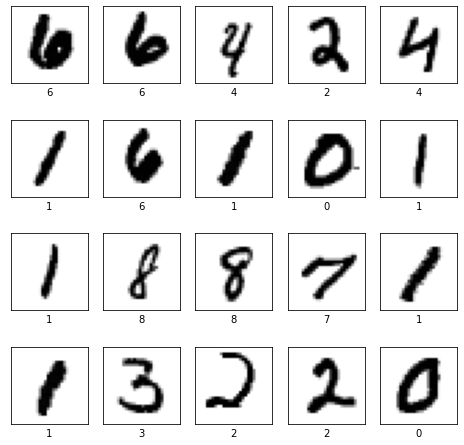

In [ ]:
plt.figure(figsize=(8,8))
random_inds = np.random.choice(40000,20)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_ind])

In [ ]:
train_labels[0]

5

### **Concatenate Training and Testing Data and flatten images into 784 X 1**


In [ ]:
train_images = tf.reshape(train_images,shape=[train_images.shape[0],784])
print("Shape of training data after flattening: ",train_images.shape)
test_images = tf.reshape(test_images,shape=[test_images.shape[0],784])
print("Shape of testing data after flattening: ",test_images.shape)


Shape of training data after flattening:  (60000, 784)
Shape of testing data after flattening:  (10000, 784)


In [ ]:
# Convert labels into one hot vector encodings of size 10 for each class
train_labels = tf.one_hot(train_labels,depth=10)
test_labels = tf.one_hot(test_labels,depth=10)
print("Shape of train labels after hot encoding: ",train_labels.shape)

Shape of train labels after hot encoding:  (60000, 10)


## **Train Neural Network Model**

#### **Defining the Model Parameters wih hidden layer sizes = [512,256,128], epochs = 50, learning rate = 0.1  and batchsize = 500**

In [ ]:
hidden_layer1_size = 512
hidden_layer2_size = 256
hidden_layer3_size = 128
input_size=784
output_size=10
batch_size = 500
learning_rate = 0.2
epochs = 30

In [ ]:
NN = NeuralNetwork(
    batch_size=batch_size,
    input_size=input_size,
    hidden_layer1_size=hidden_layer1_size,
    hidden_layer2_size=hidden_layer2_size,
    hidden_layer3_size=hidden_layer3_size,
    output_size=output_size,
    learning_rate = learning_rate,
    epochs = epochs
    )

In [ ]:
for i in range(epochs):
  if i%10==0:
    train_loss,train_acc = NN.train(train_images,train_labels,'sigmoid','softmax',True)
  else:
    train_loss,train_acc = NN.train(train_images,train_labels,'sigmoid','softmax',False)
  test_loss,test_acc = NN.test(test_images,test_labels,'sigmoid','softmax')
  print("After Epoch {} : \t train_loss: {:.2f}   ||   train_accuracy: {:.2f}%".format(i+1,train_loss,train_acc*100))
test_loss,test_acc = NN.test(test_images,test_labels,'sigmoid','softmax')
print("Final Accuracy after {} epochs: \t test_loss : {:.2f}    ||  test_accuracy: {:.2f}%".format(epochs,test_loss,test_acc*100))


After Epoch 1 : 	 train_loss: 22239.75   ||   train_accuracy: 25.80%
After Epoch 2 : 	 train_loss: 12124.12   ||   train_accuracy: 43.57%
After Epoch 3 : 	 train_loss: 9875.55   ||   train_accuracy: 51.47%
After Epoch 4 : 	 train_loss: 8703.63   ||   train_accuracy: 56.33%
After Epoch 5 : 	 train_loss: 7948.29   ||   train_accuracy: 59.69%
After Epoch 6 : 	 train_loss: 7435.40   ||   train_accuracy: 62.20%
After Epoch 7 : 	 train_loss: 6977.34   ||   train_accuracy: 64.15%
After Epoch 8 : 	 train_loss: 6658.34   ||   train_accuracy: 65.68%
After Epoch 9 : 	 train_loss: 6386.06   ||   train_accuracy: 66.78%
After Epoch 10 : 	 train_loss: 6137.71   ||   train_accuracy: 68.06%
After Epoch 11 : 	 train_loss: 5952.74   ||   train_accuracy: 69.01%
After Epoch 12 : 	 train_loss: 5783.60   ||   train_accuracy: 69.85%
After Epoch 13 : 	 train_loss: 5590.87   ||   train_accuracy: 70.85%
After Epoch 14 : 	 train_loss: 5458.13   ||   train_accuracy: 71.56%
After Epoch 15 : 	 train_loss: 5335.60   

### **Visualing the layer outputs**

(5, 5)


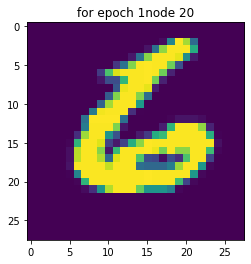

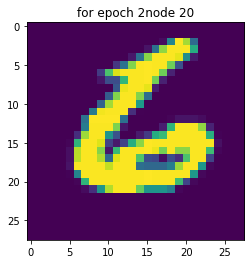

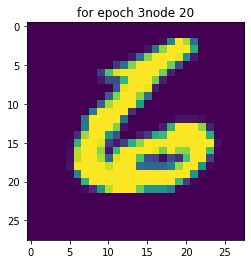

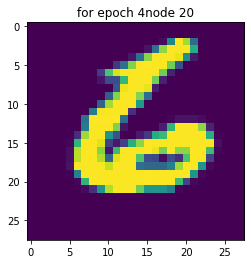

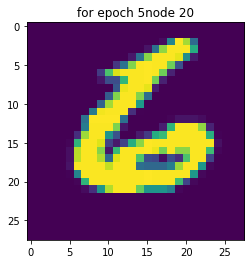

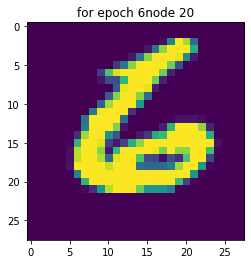

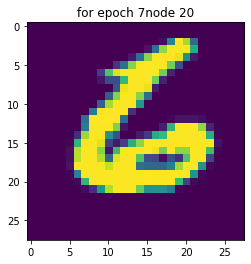

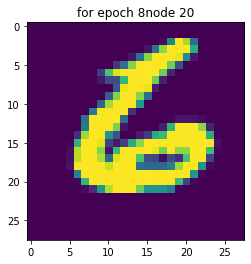

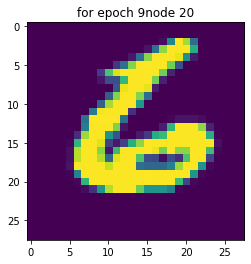

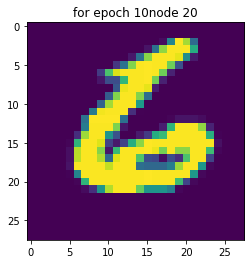

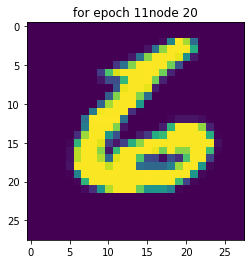

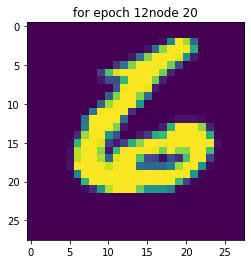

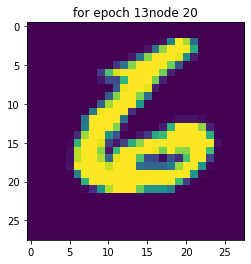

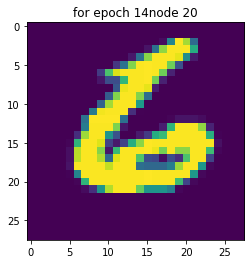

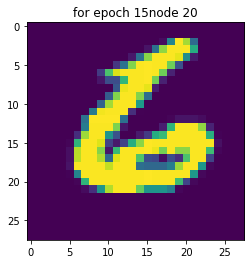

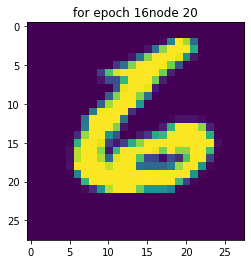

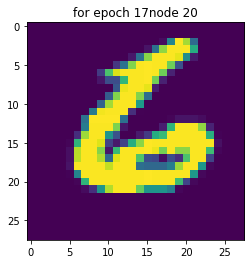

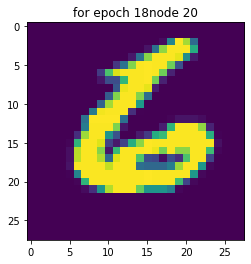

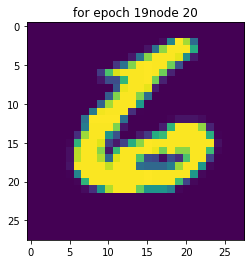

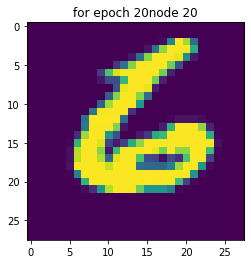

In [ ]:
As = NN.get_layer_outputs()
for e,A in enumerate(As):
  for i in range((A).shape[1]):
    col=tf.slice(A,(0,i),(784,1))
    plt.imshow(tf.reshape(col,(28,28)))
    plt.title('for epoch '+str(e*freq+1)+'node '+str(i+1))
  plt.show()

### **Visualizing the weight matrices**

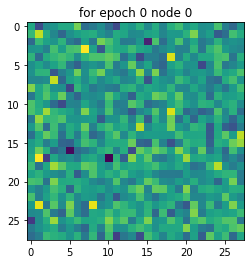

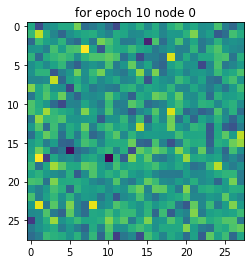

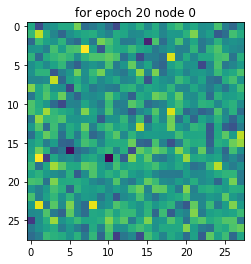

In [ ]:
# t=math.ceil(math.sqrt(classifier.layer_sizes[1]))
Ws = NN.get_weights()
ind=0
for e,W in enumerate(Ws):
  for i in range(W.shape[0]):
    col = W[:,i]
    plt.imshow(tf.reshape(col,(28,28)))
    plt.title("for epoch {} node {}".format(ind,0))
    ind+=10
    break
  plt.show()

### **Experimentation over different batch sizes**

In [ ]:
hidden_layer1_size = 512
hidden_layer2_size = 256
hidden_layer3_size = 128
input_size=784
output_size=10
batch__size = [500,1000,2000,2500]
epochs = 40
learning_rate = 0.1
train_acc = []
test_acc = []
train_loss = []
test_loss = []

for size in batch__size:
  NN = NeuralNetwork(
      batch_size=size,
      input_size=input_size,
      hidden_layer1_size=hidden_layer1_size,
      hidden_layer2_size=hidden_layer2_size,
      hidden_layer3_size=hidden_layer3_size,
      output_size=output_size,
      learning_rate = learning_rate,
      epochs = epochs
      )
  for i in range(epochs):
    tr_loss,tr_acc = NN.train(train_images,train_labels,'sigmoid','softmax',False)
  tst_loss,tst_acc = NN.test(test_images,test_labels,'sigmoid','softmax')
  train_acc.append(tr_acc)
  train_loss.append(tr_loss)
  test_acc.append(tst_acc)
  test_loss.append(tst_loss)

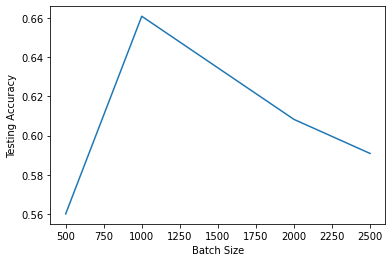

In [ ]:
plt.plot(batch__size,test_acc)
plt.xlabel("Batch Size")
plt.ylabel("Testing Accuracy")
plt.show()

Comment: If we increase the batchsize too much, it is taking more epoochs to train. So the optimal batch size is 1000

### **Experimentation over different learning rates**

In [ ]:
hidden_layer1_size = 512
hidden_layer2_size = 256
hidden_layer3_size = 128
input_size=784
output_size=10
batch_size = 2000
epochs = 50
train_acc = []
test_acc = []
learning_rates = []
train_loss = []
test_loss = []

for lr in np.arange(0.01,0.91,0.1):
  NN = NeuralNetwork(
      batch_size=batch_size,
      input_size=input_size,
      hidden_layer1_size=hidden_layer1_size,
      hidden_layer2_size=hidden_layer2_size,
      hidden_layer3_size=hidden_layer3_size,
      output_size=output_size,
      learning_rate = lr,
      epochs = epochs
      )
  learing_rates = learning_rates.append(lr)
  for i in range(epochs):
    tr_loss,tr_acc = NN.train(train_images,train_labels,'sigmoid','softmax',False)
  tst_loss,tst_acc = NN.test(test_images,test_labels,'sigmoid','softmax')
  train_acc.append(tr_acc)
  train_loss.append(tr_loss)
  test_acc.append(tst_acc)
  test_loss.append(tst_loss)
  print(tst_loss)

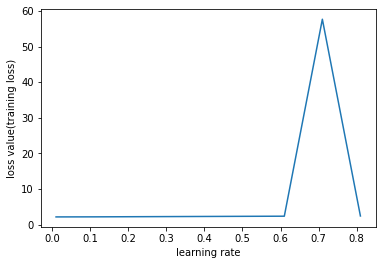

In [ ]:
plt.plot(np.arange(0.01,0.91,0.1),loss)
plt.xlabel("learning rate")
plt.ylabel("loss value(training loss)")
plt.show()

Comment: Learning rate <0.7 is good.If learning rate is high, then gradient explodes.

### **Experimentation over different hidden layer sizes**

In [ ]:
hidden_layer_sizes =[[512,256,128],[600,300,100],[128,64,32],[128,256,512]]
input_size=784
output_size=10
batch_size = 500
epochs = 40
learning_rate = 0.1
train_acc = []
test_acc = []
train_loss = []
test_loss = []

for hidden_layer in hidden_layer_sizes:
  NN = NeuralNetwork(
      batch_size=batch_size,
      input_size=input_size,
      hidden_layer1_size=hidden_layer[0],
      hidden_layer2_size=hidden_layer[1],
      hidden_layer3_size=hidden_layer[2],
      output_size=output_size,
      learning_rate = learning_rate,
      epochs = epochs
      )
  for i in range(epochs):
    tr_loss,tr_acc = NN.train(train_images,train_labels,'sigmoid','softmax',False)
  tst_loss,tst_acc = NN.test(test_images,test_labels,'sigmoid','softmax')
  train_acc.append(tr_acc)
  train_loss.append(tr_loss)
  test_acc.append(tst_acc)
  test_loss.append(tst_loss)

In [ ]:
h_axis = []
for hid in hidden_layer_sizes:
  h_axis.append(str(hid))
v_axis = []
for x in test_loss:
  v_axis.append(x.numpy())

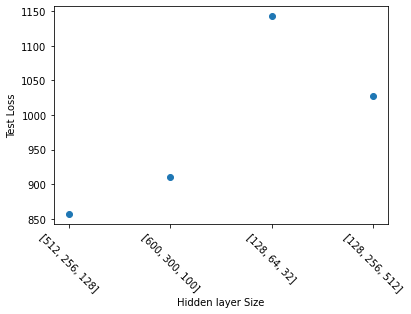

In [ ]:
plt.scatter(Hidden_layer_Sizes__,v_axis)
plt.xticks(rotation = -45)
plt.xlabel("Hidden layer Size")
plt.ylabel("Test Loss")
plt.show()

Comment: Optimal hidden layer sizes are [512,256,128] and layer sizes should decrease in general.

### **Confusion Matrix**

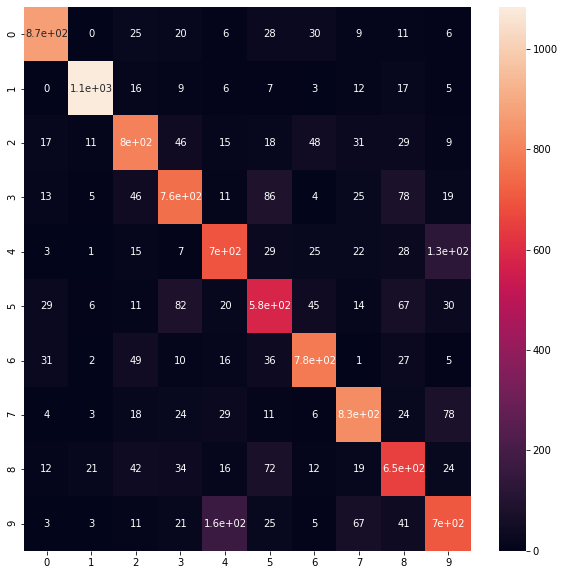

In [ ]:
y_pred_class = NN.predict_classes(test_images,test_labels,'sigmoid','softmax')
cf_matrix = confusion_matrix(y_pred_class,test_labels_class)
plt.subplots(figsize= (10,10))
sns.heatmap(cf_matrix,annot=True)

# **Import CIFAR-10 Dataset**

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)
train_labels_class = train_labels
test_labels_class = test_labels

In [ ]:
train__labels =[]
for tr_labels in train_labels:
  train__labels.append(tr_labels[0])
test__labels = []
for tst_labels in test_labels:
  test__labels.append(tst_labels[0])

### **Visualization of some of the images from dataset.**

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


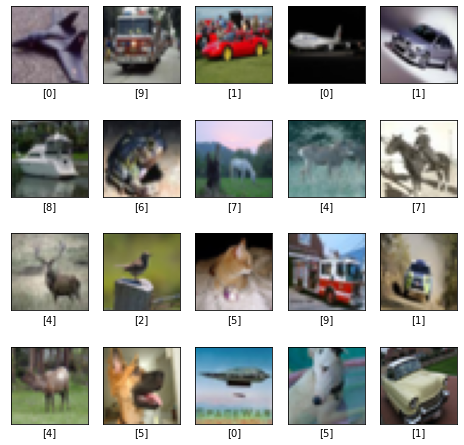

In [ ]:
plt.figure(figsize=(8,8))
random_inds = np.random.choice(40000,20)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_ind])

### **Concatenate Training and Testing Data and flatten images into 1024 X 1**


In [ ]:
train_images.shape

(50000, 32, 32, 3, 1)

In [ ]:
train_images = tf.reshape(train_images,shape=[train_images.shape[0],3072])
print("Shape of training data after flattening: ",train_images.shape)
test_images = tf.reshape(test_images,shape=[test_images.shape[0],3072])
print("Shape of testing data after flattening: ",test_images.shape)


Shape of training data after flattening:  (50000, 3072)
Shape of testing data after flattening:  (10000, 3072)


In [ ]:
#normalising the data
train_images=train_images/255
m=train_images.numpy().mean()
c=train_images.numpy().std()
a=np.full(train_images.shape,m)
train_images=(train_images-a)/c


In [ ]:
# Convert labels into one hot vector encodings of size 10 for each class
train_labels = tf.one_hot(train__labels,depth=10)
test_labels = tf.one_hot(test__labels,depth=10)
print("Shape of train labels after hot encoding: ",train_labels.shape)
print("Shape of test labels after hot encoding: ",test_labels.shape)

Shape of train labels after hot encoding:  (50000, 10)
Shape of test labels after hot encoding:  (10000, 10)


## **Train Neural Network Model**

#### **Defining the Model Parameters wih hidden layer sizes = [512,256,128], epochs = 50, learning rate = 0.1  and batchsize = 500**

In [ ]:
hidden_layer1_size = 1024
hidden_layer2_size = 512
hidden_layer3_size = 256
input_size=3072
output_size=10
batch_size = 500
learning_rate = 0.4
epochs = 30

In [ ]:
NN = NeuralNetwork(
    batch_size=batch_size,
    input_size=input_size,
    hidden_layer1_size=hidden_layer1_size,
    hidden_layer2_size=hidden_layer2_size,
    hidden_layer3_size=hidden_layer3_size,
    output_size=output_size,
    learning_rate = learning_rate,
    epochs = epochs
    )

In [ ]:
for i in range(epochs):
  if i%10==0:
    train_loss,train_acc = NN.train(train_images,train_labels,'sigmoid','softmax',True)
  else:
    train_loss,train_acc = NN.train(train_images,train_labels,'sigmoid','softmax',False)
  test_loss,test_acc = NN.test(test_images,test_labels,'sigmoid','softmax')
  print("After Epoch {} : \t train_loss: {:.2f}   ||   train_accuracy: {:.2f}%".format(i+1,train_loss,train_acc*100))
test_loss,test_acc = NN.test(test_images,test_labels,'sigmoid','softmax')
print("Final Accuracy after {} epochs: \t test_loss : {:.2f}    ||  test_accuracy: {:.2f}%".format(epochs,test_loss,test_acc*100))


After Epoch 1 : 	 train_loss: 38700.45   ||   train_accuracy: 11.59%
After Epoch 2 : 	 train_loss: 45167.42   ||   train_accuracy: 12.31%
After Epoch 3 : 	 train_loss: 48959.05   ||   train_accuracy: 12.25%
After Epoch 4 : 	 train_loss: 48355.75   ||   train_accuracy: 12.63%
After Epoch 5 : 	 train_loss: 46861.56   ||   train_accuracy: 13.69%
After Epoch 6 : 	 train_loss: 44751.33   ||   train_accuracy: 14.24%
After Epoch 7 : 	 train_loss: 40913.74   ||   train_accuracy: 14.79%
After Epoch 8 : 	 train_loss: 44766.87   ||   train_accuracy: 13.83%
After Epoch 9 : 	 train_loss: 47721.63   ||   train_accuracy: 14.52%
After Epoch 10 : 	 train_loss: 47605.67   ||   train_accuracy: 14.37%
After Epoch 11 : 	 train_loss: 44229.47   ||   train_accuracy: 15.14%
After Epoch 12 : 	 train_loss: 45550.43   ||   train_accuracy: 14.62%
After Epoch 13 : 	 train_loss: 42714.53   ||   train_accuracy: 14.69%
After Epoch 14 : 	 train_loss: 43069.61   ||   train_accuracy: 15.94%
After Epoch 15 : 	 train_loss

### **Visualizing the weight matrices**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

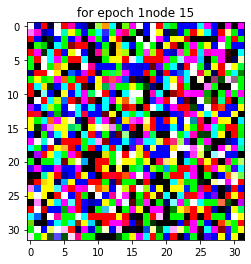

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

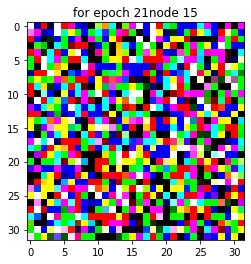

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

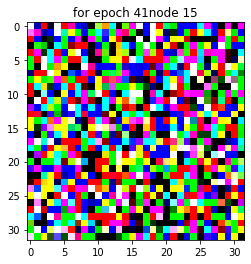

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

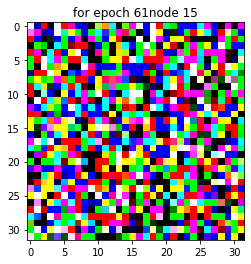

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

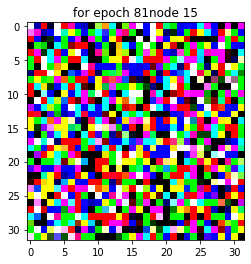

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

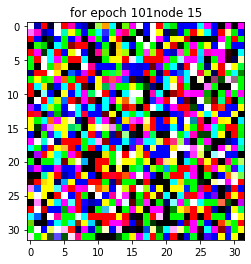

In [ ]:
Ws = NN.get_weights()

for e,W in enumerate(Ws):
  for i in range(15):
    col=tf.slice(W,(i,0),(1,3072))
    plt.imshow(tf.reshape(col,(32,32,3)))
    plt.title('for epoch '+str(e*freq+1)+'node '+str(i+1))
  plt.show()

### **Experimentation over different batch sizes**

In [ ]:
hidden_layer1_size = 1024
hidden_layer2_size = 512
hidden_layer3_size = 256
input_size=3072
output_size=10
learning_rate = 0.2
batch__size = [500,1000,2000,2500]
epochs = 30
learning_rate = 0.1
train_acc = []
test_acc = []
train_loss = []
test_loss = []

for size in batch__size:
  NN = NeuralNetwork(
      batch_size=size,
      input_size=input_size,
      hidden_layer1_size=hidden_layer1_size,
      hidden_layer2_size=hidden_layer2_size,
      hidden_layer3_size=hidden_layer3_size,
      output_size=output_size,
      learning_rate = learning_rate,
      epochs = epochs
      )
  for i in range(epochs):
    tr_loss,tr_acc = NN.train(train_images,train_labels,'sigmoid','softmax',False)
  tst_loss,tst_acc = NN.test(test_images,test_labels,'sigmoid','softmax')
  train_acc.append(tr_acc)
  train_loss.append(tr_loss)
  test_acc.append(tst_acc)
  test_loss.append(tst_loss)

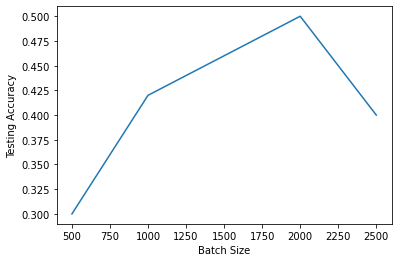

In [ ]:
plt.plot(batch__size,test_acc)
plt.xlabel("Batch Size")
plt.ylabel("Testing Accuracy")
plt.show()

Comment: Genreally as batch size increases, testing accuracy is also increases.But if it becomes too large, then model is lagging.

### **Experimentation over different epochs**

In [ ]:
hidden_layer1_size = 1024
hidden_layer2_size = 512
hidden_layer3_size = 256
input_size=3072
output_size=10
batch_size = 500
learning_rate = 0.2
epochs = 30
learning_rate = 0.1
train_acc = []
test_acc = []
train_loss = []
test_loss = []

for size in batch__size:
  NN = NeuralNetwork(
      batch_size=size,
      input_size=input_size,
      hidden_layer1_size=hidden_layer1_size,
      hidden_layer2_size=hidden_layer2_size,
      hidden_layer3_size=hidden_layer3_size,
      output_size=output_size,
      learning_rate = learning_rate,
      epochs = epochs
      )
  for i in range(epochs):
    tr_loss,tr_acc = NN.train(train_images,train_labels,'sigmoid','softmax',False)
  tst_loss,tst_acc = NN.test(test_images,test_labels,'sigmoid','softmax')
  train_acc.append(tr_acc)
  train_loss.append(tr_loss)
  test_acc.append(tst_acc)
  test_loss.append(tst_loss)

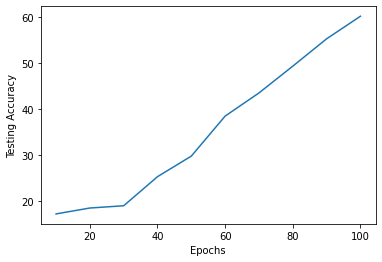

In [ ]:
plt.plot(np.arange(10,101,10),test_acc)
plt.xlabel("Epochs")
plt.ylabel("Testing Accuracy")
plt.show()

### **Confusion Matrix**

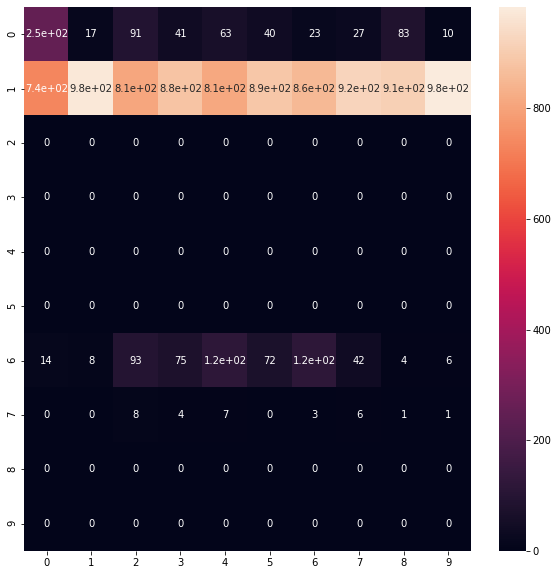

In [ ]:
y_pred_class = NN.predict_classes(test_images,test_labels,'sigmoid','softmax')
cf_matrix = confusion_matrix(y_pred_class,test_labels_class)
plt.subplots(figsize= (10,10))
sns.heatmap(cf_matrix,annot=True)

Conclusion : Neural Network is getting very good accuracy for MNIST dataset but CIFAR-10 is not getting very good accuracy. The reason for it can be that it contains more information due to RGB channels and it may require more neural netoworks for good accuracy.